## Exercice 3 : La Super-Résolution

**Objectif :** Reconstruire une image haute définition à partir d'une source dégradée.

* **Dataset :** **Flowers 102** ou **STL-10** (96x96), sinon **CIFAR-10**.
* **Seuils :** Entrée basse résolution et sortie haute résolution.
* **Méthode :** Réduisez la taille de l'image originale pour créer votre entrée.
* **Code pour Resize :** `x_train_low = tf.image.resize(x_train, [32, 32])`

In [44]:
# --- imput ---

import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import layers, models, datasets
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Rescaling, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Resizing
from tensorflow.keras.layers import Conv2DTranspose

import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [45]:
# Paramètres
BATCH_SIZE = 16
IMG_SIZE = (224, 224) # Redimensionnement automatique 

train_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,           
    validation_split=0.2,      
    subset='training',          
    seed=42                     
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    'datasets/jpg',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode=None,
    validation_split=0.2,
    subset='validation',         
    seed=42
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8189 files.
Using 6552 files for training.
Found 8189 files.
Using 1637 files for validation.


In [46]:
# --- trnsfomation into low qiality with normalisation, cration structure: (input, target) ---

LOW_SIZE = (32, 32)

def transform_low(ds):
    def to_low(image):
        image = tf.cast(image, tf.float32) / 255.0
        low_img  = tf.image.resize(image, LOW_SIZE)

        return low_img, image   # (input, target)

    ds_low = ds.map(to_low)
    ds_low = ds_low.cache().prefetch(tf.data.AUTOTUNE)

    return ds_low


train_low_ds = transform_low(train_ds)
val_low_ds = transform_low(val_ds)

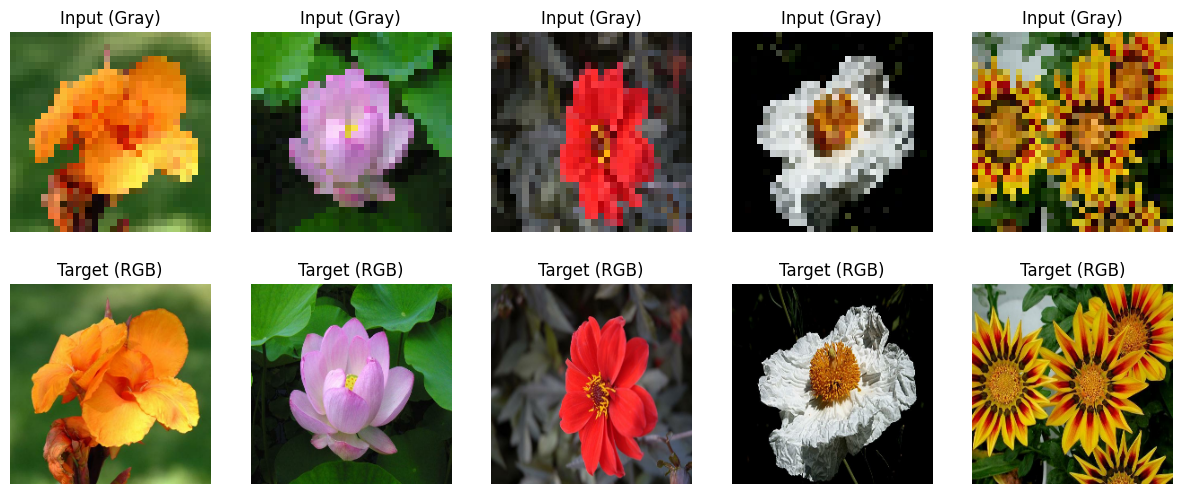

In [47]:
def show_images(ds, n=5):


    for x_batch, y_batch in ds.take(1):
        fig, axes = plt.subplots(2, n, figsize=(15, 6))
        batch_size = x_batch.shape[0]

        for i in range(n):
            idx = np.random.randint(batch_size)

            # --- grayscale (input) ---
            axes[0, i].imshow(tf.cast(x_batch[idx]*255, tf.uint8))
            axes[0, i].axis('off')
            axes[0, i].set_title('Input (Gray)')

            # --- RGB (target) ---
            axes[1, i].imshow(tf.cast(y_batch[idx]*255, tf.uint8))
            axes[1, i].axis('off')
            axes[1, i].set_title('Target (RGB)')

        plt.show()
        break

show_images(transform_low(train_ds), 5)

In [48]:
input_img = Input(shape=(32, 32, 3))  # Входное изображение 32x32

# --- Encoder ---
x = Conv2D(64, 3, activation='relu', padding='same')(input_img)   # 32x32
x = MaxPooling2D((2,2), padding='same')(x)                         # 16x16

x = Conv2D(128, 3, activation='relu', padding='same')(x)           # 16x16
x = MaxPooling2D((2,2), padding='same')(x)                         # 8x8

x = Conv2D(256, 3, activation='relu', padding='same')(x)           # 8x8
x = MaxPooling2D((2,2), padding='same')(x)                         # 4x4

# --- Decoder ---
x = Conv2DTranspose(256, 3, strides=2, activation='relu', padding='same')(x)  # 8x8
x = Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x)  # 16x16
x = Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(x)   # 32x32
x = Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')(x)   # 64x64
x = Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same')(x)   # 128x128
x = Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same')(x)    # 256x256 (можно потом обрезать)
x = Resizing(224, 224)(x)
# --- Выход --- 
output_img = Conv2D(3, 3, activation='sigmoid', padding='same')(x)  # 256x256x3

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_37             │ (None, 8, 8, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_39             │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 64, 64, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 128, 128, 16)   │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 256, 256, 8)    │         1,160 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_2 (Resizing)           │ (None, 224, 224, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 224, 224, 3)    │           219 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,354,195 (5.17 MB)

 Trainable params: 1,354,195 (5.17 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# --- autoencoder fitting ---

history = autoencoder.fit(
    train_low_ds,          # ВХОД → grayscale
    epochs=5,
    validation_data=val_low_ds  # Валидация
)

Epoch 1/5
 53/410 ━━━━━━━━━━━━━━━━━━━━ 50s 142ms/step - loss: 0.0883

AbortedError: Graph execution error:

Detected at node StatefulPartitionedCall/gradient_tape/functional_7_1/conv2d_transpose_37_1/conv_transpose/Conv2DBackpropFilter defined at (most recent call last):
<stack traces unavailable>
Operation received an exception:Status: 1, message: could not create a memory object, in file tensorflow/core/kernels/mkl/mkl_conv_grad_filter_ops.cc:685
	 [[{{node StatefulPartitionedCall/gradient_tape/functional_7_1/conv2d_transpose_37_1/conv_transpose/Conv2DBackpropFilter}}]] [Op:__inference_multi_step_on_iterator_12188]